In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
from pprint import pprint

from jieba_postag_converter import get_postag_dict

In [42]:
def rank_by_unalighed_diff_counts_btw_methods(df,corpus='cejc',situation='apology',sen_type='query', reverse=False):
    # FOR creating words ranking graph and pos rangling graph
    cols = {'primitive form':'word count', 'pos':'pos count'}
    for label_col, data_col in cols.items():
        df[data_col] = df.groupby(['corpus', 'situation', 'method', 'sentence type', 'difference type',label_col])['index'].transform('count')
        df_word = df.drop_duplicates(['corpus', 'situation', 'method', 'sentence type', 'difference type',label_col]).sort_values(by=data_col, ascending=False)
        df_word = df_word.dropna(subset=[label_col])

        # GET data for 1 graph
        difference_type = ['del','add']
        method_type = ['translated','rewrited']
        data, labels = [], []
        for diff_type in difference_type:
            _temp_w, _temp_wv = [], [] 
            for method in method_type:
                _temp_w.append(df_word[(df_word['corpus']==corpus)&(df_word['situation']==situation)&(df_word['method']==method)&(df_word['sentence type']==sen_type)&(df_word['difference type']==diff_type)][label_col])
                _temp_wv.append(df_word[(df_word['corpus']==corpus)&(df_word['situation']==situation)&(df_word['method']==method)&(df_word['sentence type']==sen_type)&(df_word['difference type']==diff_type)][data_col])
            # PUT data into dictionary, COUNT freq., CALCULATE (rewrited - translated) and SORT them
            dic = {}
            for i,(wline,vline) in enumerate(zip(_temp_w,_temp_wv)):
                for j,(w,v) in enumerate(zip(wline,vline)):
                    if w in dic:
                        dic[w]['each'][i]=v
                        v = v*-1 if i==0 else v
                        dic[w]['diff']=dic.get(w,dic.get('diff',0))['diff']+v
                    else:
                        tmp = [0,0]
                        tmp[i] = v
                        v = v*-1 if i==0 else v
                        dic.setdefault(w,{'each':tmp,'diff':v})
            dic = sorted(dic.items(),key=lambda x:x[1]['diff'],reverse=True)
            # pprint(dic)
            # exit()
            data_w, data_wv = [],[[],[]]
            for key, values in dic:
                data_w.append(key)
                data_wv[0].append(values['each'][0])
                data_wv[1].append(values['each'][1]) 
            labels.append(data_w)
            data.append(data_wv)
        
        # CREATE GRAPH
        ncol=1
        nrow=2
        width = 0.15
        max_n_x = 100
        plt.style.use('fivethirtyeight')
        plt.rcParams['font.sans-serif'] = ['SimHei']
        fig = plt.figure(figsize=(25,8))
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        for i, d in enumerate(data):    
            d = np.array(d)
            n_x = max_n_x if d.shape[1]>=max_n_x else d.shape[1]
            left = np.arange(n_x)
            # SHARE the range of y-axis
            if i>=1:
                ax = plt.subplot2grid((nrow, ncol), (i//ncol, i%ncol),sharey=prev_ax)
            else:
                ax = plt.subplot2grid((nrow, ncol), (i//ncol, i%ncol))
            ax.set_ylim(0,50)
            
            # CONVERT pos tag labels
            try:
                pos_dic = get_postag_dict()
#                 labels[i] = [pos_dic[l[0]] for l in labels[i]] # Upper category
                labels[i] = [pos_dic[l] for l in labels[i]]
            except KeyError as e:
#                 print(e)
#                 print(labels[i][0])
                pass

            if reverse == True:
                plt.bar(left,           d[0][-n_x:],   width=width, align='center',label='translated')
                plt.bar(left+width,     d[1][-n_x:],   width=width, align='center',label='rewrited')
                plt.xticks(left+width/2, labels[i][-n_x:],rotation=45,fontsize='small')
            else:
                plt.bar(left,           d[0][:n_x],   width=width, align='center',label='translated')
                plt.bar(left+width,     d[1][:n_x],   width=width, align='center',label='rewrited')
                plt.xticks(left+width/2, labels[i][:n_x],rotation=45,fontsize='xx-small')
            title = "Diff_ranking"+" "+corpus+" "+situation+" "+sen_type+" "+difference_type[i]+" "+data_col
            plt.title(title, fontsize='x-large')
            ax.legend(fontsize='large')
            prev_ax = ax 

        fig.suptitle(f'unaligned {label_col} diff-ranking: {corpus} {situation} {sen_type}', fontsize=25)
        save_path = f"graph/diff_{label_col}_ranking_{corpus}_{situation}_{sen_type}.png"
        plt.show()
        print(labels)
        print(data)
        
#         plt.savefig(save_path)
#         plt.close(fig) 
    return 0


In [43]:
t_path = "analysis_table.csv"
df = pd.read_csv(t_path)

# # For Only CONTENT WORDS
# t_path = "analysis_table_upper.csv"
# df = pd.read_csv(t_path)
# # get only content words
# content_words = [   '名詞','動詞','形容詞','','','',
#                     'a','i','j','l','n','t','v'
#                 ]
# df = df[df['pos'].isin(content_words)]

# MPDD apology
#### -  对不起

对第三者的（label miss）

[ 127 ] original    query : 您 别 这么 说 ， 是 我 __对不起__ 她 ， 帮不了 她 。

[ 127 ] translated  query : そんな こと 言わ ないで 、 反省 して 助け られ ない の は 私 な んだ から 。

[ 127 ] rewrited    query : やめて よ 。 悪い の は 助け られ ない 私 だ から 。

#### -  抱歉

- Culture miss

日文：若直接翻譯的話，攻擊力極高的“抱歉”。（有点类似用中文骂脏话那种）

[ 14  ] original    query : 高 老师 ， 这话 你 讲 了 多少 遍 了 ， 我 已经 听烦 了 。 现在 你 给 我 听 好 ， 我 很 __抱歉__ ， 我 对 你 现在 没有 感觉 ， 可能 今后 也 永远 不会 有 感觉 的 ， 我 的话 可能 说直 了 点 ， 请 你 不必 介意 ， 希望 今后 我们 多 谈点 工作 上 的 事 ， 尽量少 谈 或者 不 谈 个人 问题 行 吗 ？

[ 14  ] translated  query : ガオ さん 、 何 度 言って も 聞き 飽きた 。 今 、 私 の 話 を 聞いて ください 、 __ごめんなさい__ 、 私 は 今 は あなた に 感情 を 持って い ませ ん し 、 おそらく 今後 も そう する こと は ない でしょう 、 私 の 言葉 は 少し ストレート かも しれ ませ ん 、 気 に し ないで ください 、 私 は 今後 、 仕事 の 問題 に ついて もっと 話 を する こと を 願って い ます 、 そして 、 個人 的な 問題 に ついて は 、 あまり 話さ ない か 、 または 話さ ない ように して ください 、 いい です か ？

[ 14  ] rewrited    query : いい加減に して ください 。 私 たち は そういう 関係 じゃ ない し 、 これ から も そう は なり ませ ん 。

- Translation miss

只是沒有重複講。

[  5  ] original    query : 师母 ， 我 很 __抱歉__ ， 我 对不起 你 ， 请留步 吧 ！

[  5  ] translated  query : 奥様 、 __ごめんなさい__ 、 __ごめんなさい__ 、 ここ に いて ください ！

[  5  ] rewrited    query : 奥様 、 すみません 。 もう 少し お 話し ましょう よ 。

#### - 请原谅

- Culture miss?

日文：一般在關係裡有奴隸感才會講。

[  8  ] original    query : 陈 主任 ， 今年 暑假 我 回家 ， 妻子 患 “ 脑血栓 ” 导致 下身 瘫痪 了 。 家里 没有 亲人 照顾 ， 我 只好 带 着 她 上 大学 。 在 这里 租 了 间 民房 住 比 在 校内 方便 些 。 __请__ 领导 __原谅__ 我 。

[  8  ] translated  query : 陳 監督 、 今年 の 夏 、 妻 が 脳 血栓 症 で 半身 不随 に なって 帰宅 し ました 。 家 で 面倒 を 見て くれる 家族 が い なかった ので 、 一緒に 大学 に 連れて 行き ました 。 私 は ここ の 個室 を 借り ました が 、 キャンパス 内 より も 便利です 。 __許して ください 。__

[  8  ] rewrited    query : 主任 、 すみません 。 今年 の 夏 、 妻 が 脳 血栓 で 倒れて 半身 不随 に なり ました 。 大学 の 中 より 、 外 に 部屋 を 借りる 方 が 便利だった ので …… 。 すみません 。

[ 21  ] original    query : 爸 ， 我 晚来 了 一步 ， 女儿 不孝 ， __请 爸爸 多多 原谅 。__

[ 21  ] translated  query : お 父さん 、 遅刻 し ました 、 娘 が 恩知らずな ので 、 もっと __許して ください 。__

[ 21  ] rewrited    query : お 父さん 、 遅れて ごめんなさい 。

[ 35  ] original    query : 爸 ！ 我 错 了 还 不行 嘛 ？ 我 真诚地 向 您 道歉 ！ __请 你 原谅 我__ ！ 我 保证 ， 从今以后 ， 我 什么 都 听 你 的 ， 你 让 我 做 什么 我 就 做 什么 ， 再也 不 惹 你 生气 了 ， 成 吗 ？

[ 35  ] translated  query : パパ ！ 勘違い して は いけない の か ？ 心から お 詫び 申し上げ ます ! __許して ください__ ！ 約束 する よ 、 これ から は 君 の 望む こと は 何でも する 、 君 の 望む こと は 何でも する 、 もう 二度と 君 を 怒ら せ ない 、 いい ね ？

[ 35  ] rewrited    query : 私 が まちがって い ました 。 これ から は ちゃんと お 父さん の 話 を 聞いて 、 なんでも 言わ れた とおり に する から 、 それ じゃ だめです か ？

#### - 才

- Culture miss

日文：若有 才，聽起來把自己做的事情正當化（=藉口）

[ 75  ] original    query : 总经理 ， 真 不好意思 啊 ！ 我 看见 那 败家子 就 会 火冒三丈 ！ 所以 __才__ 忍不住 想 骂 他 一顿 。

[ 75  ] translated  query : 総 支配人 さん 、 本当に すみません で した ! あの 負け 犬 を 見る と 腹 が 立って くる ! __だ から こそ__ 、 叱ら ず に は い られ なかった 。

[ 75  ] rewrited    query : すみません 社長 、 あの バカ を 見たら 我慢 でき なくて 、 つい 怒って しまい ました 。

[ 80  ] original    query : 科 ， 抱歉 ！ 我 并 没有 把 你 看成 那种 人 ！ 只是 你 莫名其妙 地 拿出 这些 照片 ， 我 __才 不得不__ 那样 想 ！ 有件事 我 也 想 告诉 你 ， 只是 不 知道 该 怎样 开口 ！ 科 ， 你 一定 还 记得 我 与 你 结婚 时 ， 已 不是 完璧 了 ！

[ 80  ] translated  query : コエ さん 、 ごめんなさい ！ そんな 人 に は 見え なかった ! 何となく この 写真 を 思い ついた ので 、 そう 思わ ざる __を 得 ませ ん で した__ ! 伝え たい こと が ある んだ けど 、 どう 言えば いい の か わから ない ！ 」 と いう 方 も いらっしゃる ので は ない でしょう か ？ コエ 覚えて おいて くれ 結婚 した 時 私 は もう 完璧じゃ なかった んだ ！

[ 80  ] rewrited    query : ごめんなさい 。 そういう つもり じゃ なかった の 。 ただ 、 あなた が 意味 あり げ に 写真 を 持って た から 、 ちょっと 不安に なった だけ で 。 言い たい こと が あった んだ けど 、 どう いって いい か わから なかった ！ ねえ 、 結婚 した とき 、 もう 私 が 処女 じゃ なかった の 覚えて る でしょ ？

[ 82  ] original    query : 丽芸 ， 对不起 ！ 我 不是 有心 要害 你 大哥 ， 我 当时 只是 一时 情急 __才__ 昏 了 头脑 ！ 丽芸 ， 请 你 告诉 我 你 大哥 他 怎么样 了 ？

[ 82  ] translated  query : リーワン 、 ごめんなさい ！ お 兄さん を 傷つける つもり は なかった んだ けど 、 慌てて __しまって__ 気 が 狂い そうに なった 。 リーワン 、 お 兄さん の 様子 を 教えて ください 。

[ 82  ] rewrited    query : ごめんなさい 、 お 兄さん を 傷つける に は なかった の 。 ただ 切羽詰まって て 、 頭 に 血 が 上っちゃ った だけ で …… 。 お 兄さん が どう して る か 教えて くれ ない ？

- Translation miss

習慣用語？

[ 98  ] original    query : 是 我 说 对不起 __才 对__ 。 我 知道 你 对 我 的 感情 ， 但是 … … 感情 是 两个 人事 ， 你 明白 吗 ？

[ 98  ] translated  query : 謝る の は __当然の こと です__ 。 気持ち は わかる けど 、 ...... 気持ち は 2 人 の 人事 です 、 わかり ます か ？

[ 98  ] rewrited    query : 謝る の は 私 の 方 だ よ 。 そういう 風 に 思 わ てる って 知って た んだ から 。 でも 、 そういう の は 二 人 の こと だ から 、 ね ？

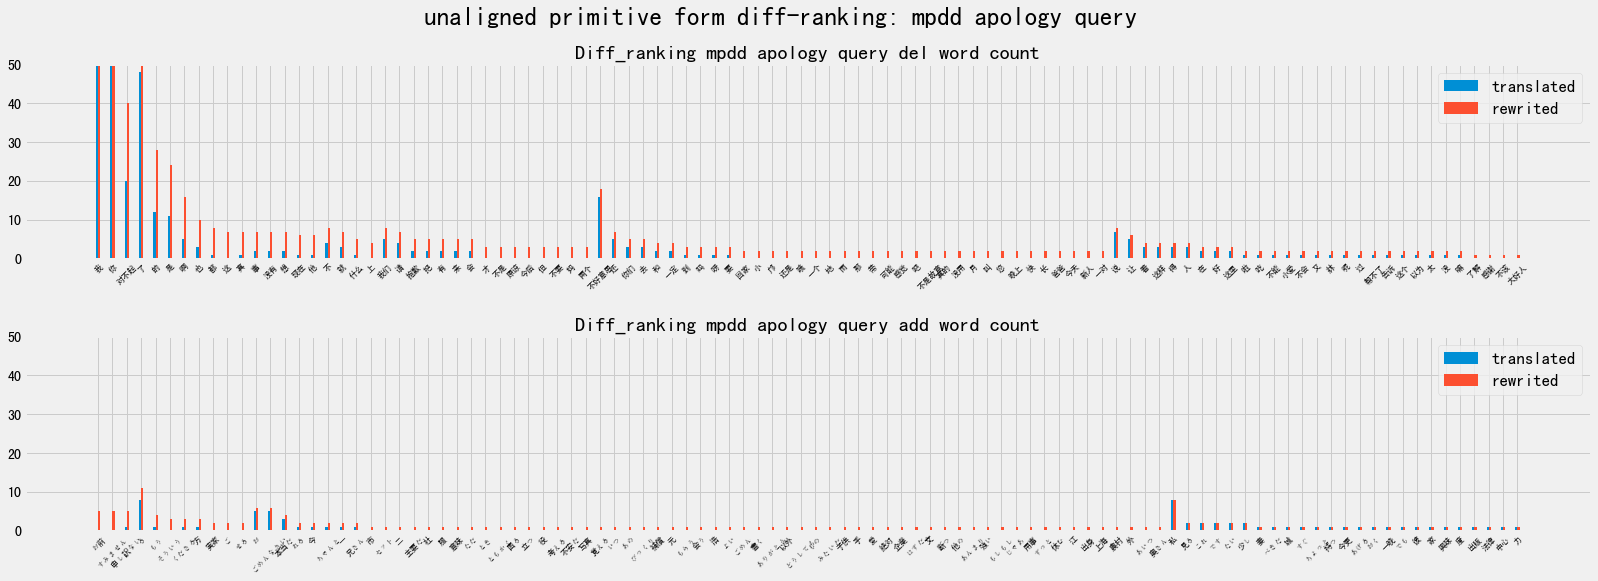

[['我', '你', '对不起', '了', '的', '是', '啊', '也', '都', '这', '真', '事', '没有', '想', '现在', '他', '不', '就', '什么', '上', '我们', '请', '抱歉', '把', '有', '来', '会', '才', '不是', '原谅', '今后', '但', '不要', '妈', '两个', '不好意思', '还', '你们', '去', '和', '一定', '到', '吗', '呀', '要', '回家', '小', '邝', '还是', '哦', '一个', '地', '而', '那', '带', '可能', '感觉', '吧', '不是故意', '真的', '没用', '月', '叫', '您', '晚上', '快', '长', '爸爸', '今天', '新人', '一对', '说', '让', '着', '这样', '得', '人', '在', '好', '这里', '啦', '吃', '不能', '小爱', '不会', '又', '牀', '呢', '过', '帮不了', '告诉', '这个', '以为', '太', '没', '嘛', '了解', '感谢', '不该', '大好人', '毁', '谈', '那种', '要求', '些', '主任', '那就好', '产', '行', '帮忙', '女孩', '刚才', '愿', '不必', '听烦', '小弟弟', '以小人之心', '那何', '婕妤', '一切', '说直', '火冒三丈', '看见', '永远', '心灵', '希望', '后', '走', '祝', '以后', '多少', '讲', '认识', '介意', '这话', '高', '婚姻', '本来', '心好疼', '女儿', '点儿', '家里', '哎哟', '课本', '的话', '小姐', '大半天', '馒头', '带来', '别生气', '不了', '明白', '乖', '谁', '生', '爱人', '瞒', '儿子', '点', '道歉', '向', '不行', '医院', '大', '送到', '学习', '一篇', '孙', '不然', '请假', '重要', '好好学习', '晚来', '脑血栓', '老人家', '导致', 

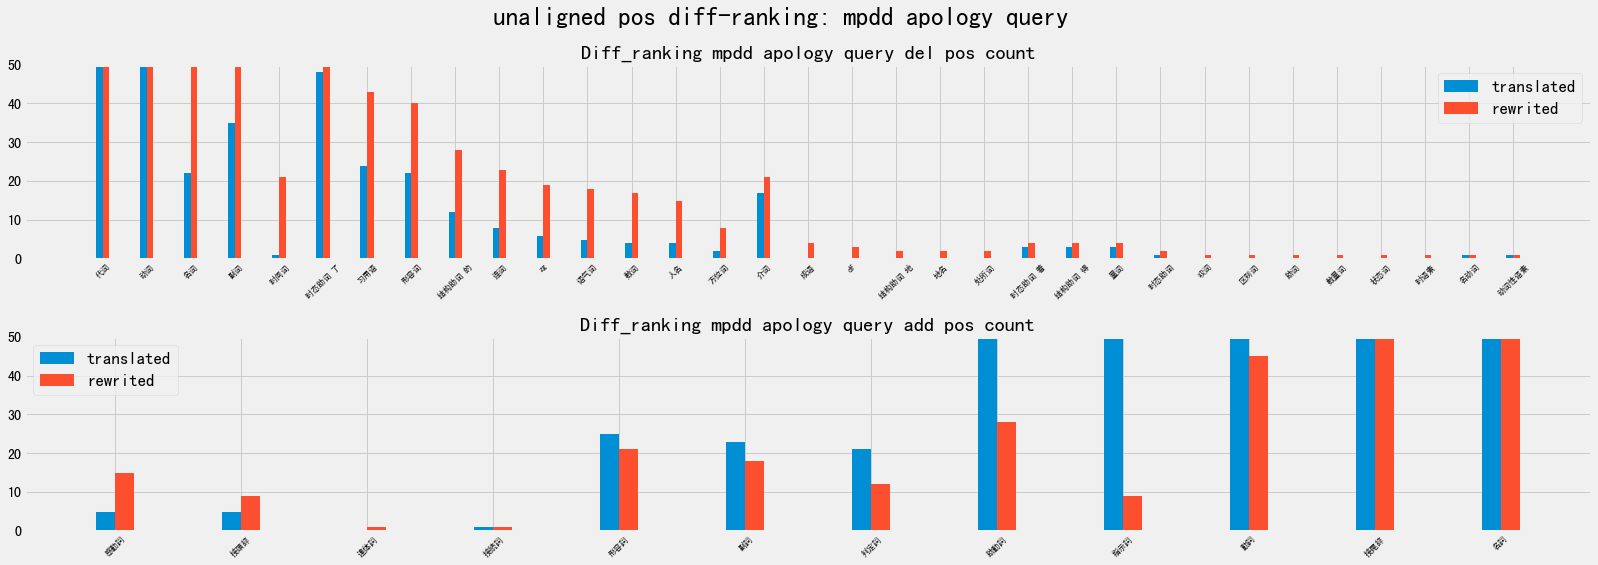

[['代词', '动词', '名词', '副词', '时间词', '时态助词 了', '习用语', '形容词', '结构助词 的', '连词', 'zg', '语气词', '数词', '人名', '方位词', '介词', '成语', 'df', '结构助词 地', '地名', '处所词', '时态助词 着', '结构助词 得', '量词', '时态助词', '叹词', '区别词', '助词', '数量词', '状态词', '时语素', '名动词', '动词性语素'], ['感動詞', '接頭辞', '連体詞', '接続詞', '形容詞', '副詞', '判定詞', '助動詞', '指示詞', '動詞', '接尾辞', '名詞']]
[[[228.0, 84.0, 22.0, 35.0, 1.0, 48.0, 24.0, 22.0, 12.0, 8.0, 6.0, 5.0, 4.0, 4.0, 2.0, 17.0, 0, 0, 0, 0, 0, 3.0, 3.0, 3.0, 1.0, 0, 0, 0, 0, 0, 0, 1.0, 1.0], [332.0, 176.0, 60.0, 72.0, 21.0, 67.0, 43.0, 40.0, 28.0, 23.0, 19.0, 18.0, 17.0, 15.0, 8.0, 21.0, 4.0, 3.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [[5.0, 5.0, 0, 1.0, 25.0, 23.0, 21.0, 68.0, 64.0, 113.0, 142.0, 164.0], [15.0, 9.0, 1.0, 1.0, 21.0, 18.0, 12.0, 28.0, 9.0, 45.0, 66.0, 79.0]]]


0

In [44]:
corpus = 'mpdd'
situation = 'apology'

rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'query')

# MPDD apology res

#### 什么

Culture miss? 

[ 123 ] original    res   : 你 这 是 说 __什么__ 话 ？ 我 愿意 照顾 你 ， 照顾 你 一辈子 。

[ 123 ] translated  res   : __何__ を 言って る んだ ？ 私 は あなた の こと を 一生 大切に し たい と 思って い ます 。

[ 123 ] rewrited    res   : 好きで やって る んです よ 。 一生 だって 面倒 を 見 ます 。

[ 87  ] original    res   : 说 这些 有 __什么__ 意思 ？ 既然 不 知道 说 什么 ， 那 就 什么 都 不 说 了 。 我 也 只能 帮 你 拿 拿 东西 。 别的 根本 帮不上 你 。

[ 87  ] translated  res   : __何__ が 言い たい の ？ 何 を 言って いい か わから ない ので 、 何も 言わ ない 。 私 は あなた の 物 を 運ぶ の を 手伝う こと しか でき ませ ん 。 他 に は 何の 役 に も 立ち ませ ん 。

[ 87  ] rewrited    res   : 知ら ない よ 。 荷物 を 運んで やる くらい の こと は できる けど 、 それ 以外 は 何も でき ない よ 。

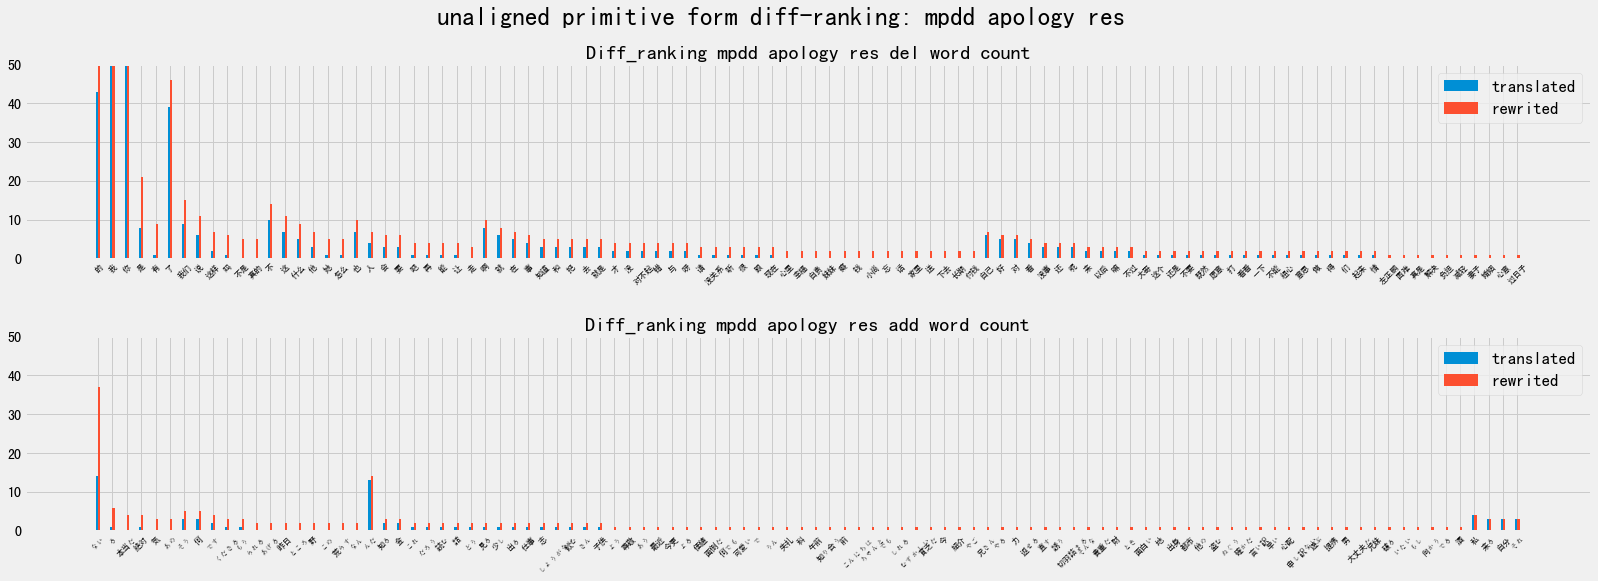

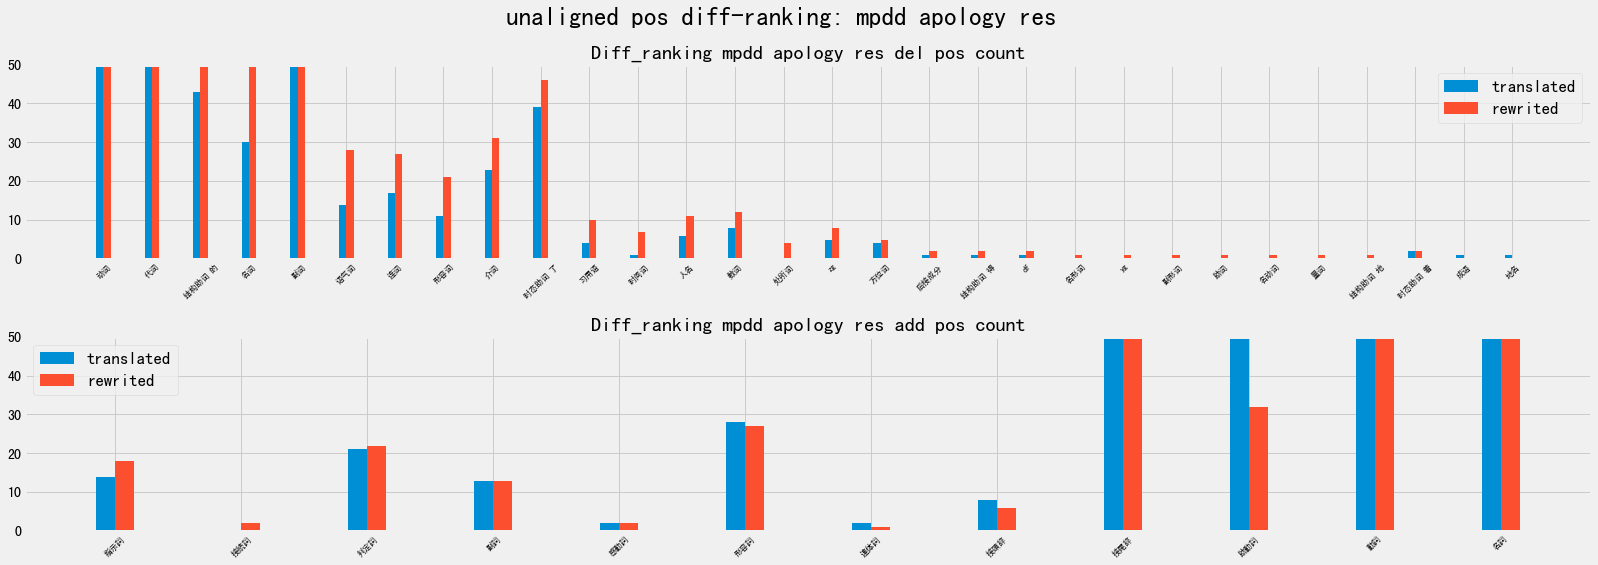

0

In [5]:
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'res')

# MPDD request

##### 请

- Traslation miss

politeness

[ 22  ] original    query : 师弟 ， __请__ 你 猜猜 我 是 何方 人氏 ？

[ 22  ] translated  query : 兄さん 、 私 が どこ から 来た か 当てて __ください__ 。

[ 22  ] rewrited    query : どこ 出身 か 当てて みて 。

[ 82  ] original    query : __请__ 你 能 看 在 我 爸爸 老 革命 的 脸上 ， 跟 我 松通 下 关系 ， 机不可失 ， 失不再来 呀 ！ 请 帮帮忙 吧 ！ 我 永远 不会 忘记 你 的 ！

[ 82  ] translated  query : 頼む から 父 の 革命 家 の 顔 の ため に も 解放 して __くれよ__ ！ よろしく お 願い し ます ！ 」 と 言って い ました 。 君 の こと は 忘れ ない よ ！

[ 82  ] rewrited    query : 父 の 革命 家 と して の 顔 を 立てて 、 __お 願い 出来 ませ ん か__ 。 お 願い いたし ます 。

 - Culture miss
 
 直接的要求
 
 [ 62  ] original    query : 这 是 同学 们 给 你 妻子 的 一点 心意 __请__ 你 收下 。
 
[ 62  ] translated  query : 同級生 から 奥様 へ の ささやかな 感謝 の 印 です 。 受け取って ください 。

[ 62  ] rewrited    query : こちら 、 よろしければ 使って ください 。

[ 63  ] original    query : 你们 快 坐 ， 请 快 坐下 。 慢慢说 吧 。

[ 63  ] translated  query : お前 ら 早く 座って くれよ 。 焦ら ないで

[ 63  ] rewrited    query : 座って ください 。 落ち着いて お 話し ましょう 。

##### 能

- Translation miss

politeness

[ 43  ] original    query : 师母 ， 您 对 我们 每个 同学 应该 都 是 父母 之 心 吧 ， 应该 都 是 平等 的 。 听说 我 班 杨伟 同学 正在 追求 刘 豔 ， 但是 刘 豔 不 接受 他 的 爱 ， 您 __能 不能__ 给 刘 豔 做 点 思想 工作 ， 给 他们 俩 搭 撘 桥 ， 牵 牵线 呢 ？

[ 43  ] translated  query : 先生 の お 母 様 、 生徒 一人一人 の 親 と して 、 対等である べきです 。 クラス の 楊貴妃 が 劉延 を 追い かけて いる と 聞いた のです が 、 劉延 が 彼 の 愛 を 受け入れて くれ ない ので 、 劉延 の ため に 何 か 考え 事 を して 、 二 人 に 橋渡し と 勝負 を して __くれ ませ ん か ？__

[ 43  ] rewrited    query : 私 たち みんな あなた の 学生 です よ ね 。 楊 さん は 劉 さん が 好き みたいだ けど 、 上手く いって い ない らしい んです よ 。 お 手伝い して __あげて ください ませ ん か ？__

- Culture miss

明明是拜託別人，罵太多

[ 131 ] original    query : 哎呀 ！ 你 能 不能不 抽 了 ？ __都 呛 死 人 了 ！__

[ 131 ] translated  query : おっと タバコ は やめて くれ ます か ？ __窒息 死 し そうだ ！__

[ 131 ] rewrited    query : タバコ は やめて 。

[ 161 ] original    query : 好 啦 ！ 不要 再 吵 啦 ！ __烦死 了 ！__ 能 不能 静一静 ！

[ 161 ] translated  query : いい ぞ ！ やめて ！ __めんどく せ え なー 。__ 静かに して くれ ！

[ 161 ] rewrited    query : うるさい 。 静かに して くれ ない か 。

##### -

- Culture miss

講過多自己不做的理由

[ 321 ] original    query : 这次 又 得 麻烦 你 了 ， __你 看 这 材料 的 事 我们 又 不 懂 ， 买 多少 买 什么样 的 都 不 知道__ ， 你 再 受点累 ， 去 帮忙 置办 一下 。

[ 321 ] translated  query : この 時間 は 、 __あなた が 再び あなた を 困ら せ なければ なら ない 、 あなた は この 物質 的な もの を 見て 、 私 たち は 知ら ない 、 どのような 種類 の もの を 買う ため に どの くらい の 量 を 購入 し __、 あなた は もう 少し 苦しむ 、 少し を 購入 する の を 助ける ため に 行く 。

[ 321 ] rewrited    query : 頼む よ 。 この 辺 は わから ない から 、 どれ だけ 買えば いい かも わから ない し 。 悪い けど 、 お 願い でき ない か な 。

[ 290 ] original    query : 小冬 ， 这个 、 这个 主持会议 的 前言 你 帮 我 写 一下 吧 。 __我 、 我 事情 太 多 ， 实在 是 忙不过来 了 。__

[ 290 ] translated  query : シャオドン 、 これ は 、 この ホスト セッション の 前文 ...... あなた が 私 の ため に 書く こと が でき ます 。__私 、 やる こと が 多 すぎて 、 本当に 忙しい んです 。__

[ 290 ] rewrited    query : あの 、 会議 の 最初の あいさつ を 書いて くれ ない か な 。 ちょっと 忙しくて 。

[ 334 ] original    query : 那 真是太 麻烦 你 了 ， 要不是 时间 紧 我 也 不会 开 这个 口 。

[ 334 ] translated  query : マジ で めんどく せ え な 、 時間 に 追わ れて なかったら 開けて ない わ

[ 334 ] rewrited    query : よろしく お 願い いたし ます 。
##### 麻烦

- Translation miss

[ 147 ] original    query : 那也好 。 那 真是 麻烦 你 了 。

[ 147 ] translated  query : それ は それ で いい んです 。 それ は それ で 大変な こと だ 。

[ 147 ] rewrited    query : それ で いい よ 。 お 願い 。


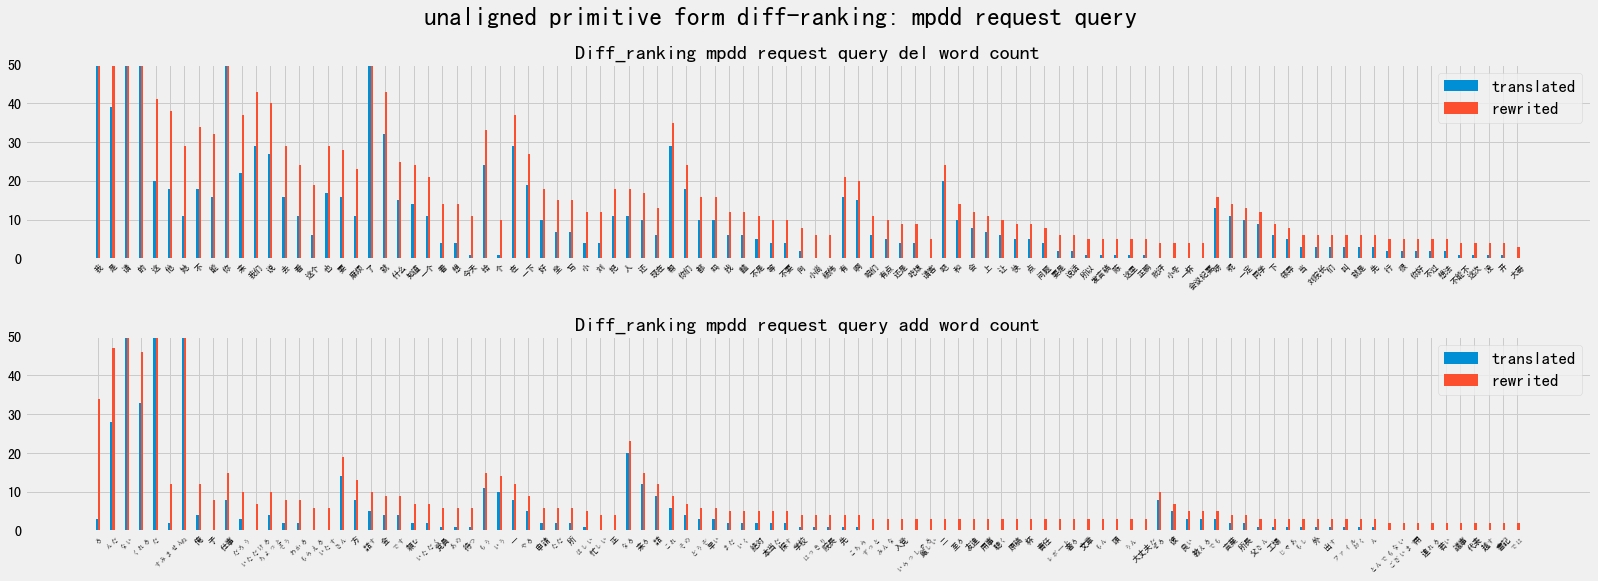

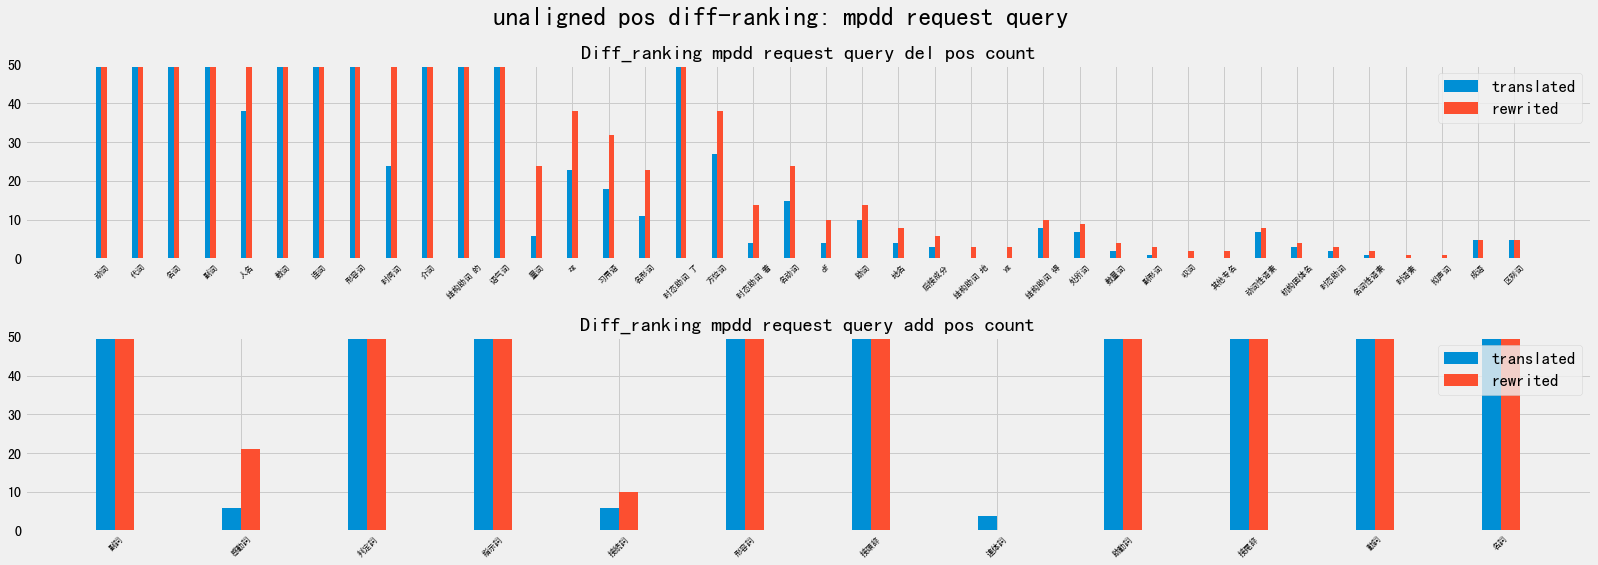

0

In [6]:
corpus = 'mpdd'
situation = 'request'
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'query')

# MPDD request res

##### 應該
- Translation miss

習慣用語

[ 152 ] original    res   : 这 是 应该 的 。

[ 152 ] translated  res   : それ が 本来 あるべき 姿 な のです 。

[ 152 ] rewrited    res   : 大丈夫 。

[ 333 ] original    res   : 应该 的 。 大哥 ， 我们 走 吧 。
[ 333 ] translated  res   : そう あるべき だ 兄さん 、 行こう よ 。
[ 333 ] rewrited    res   : もちろん 。 行こう 。

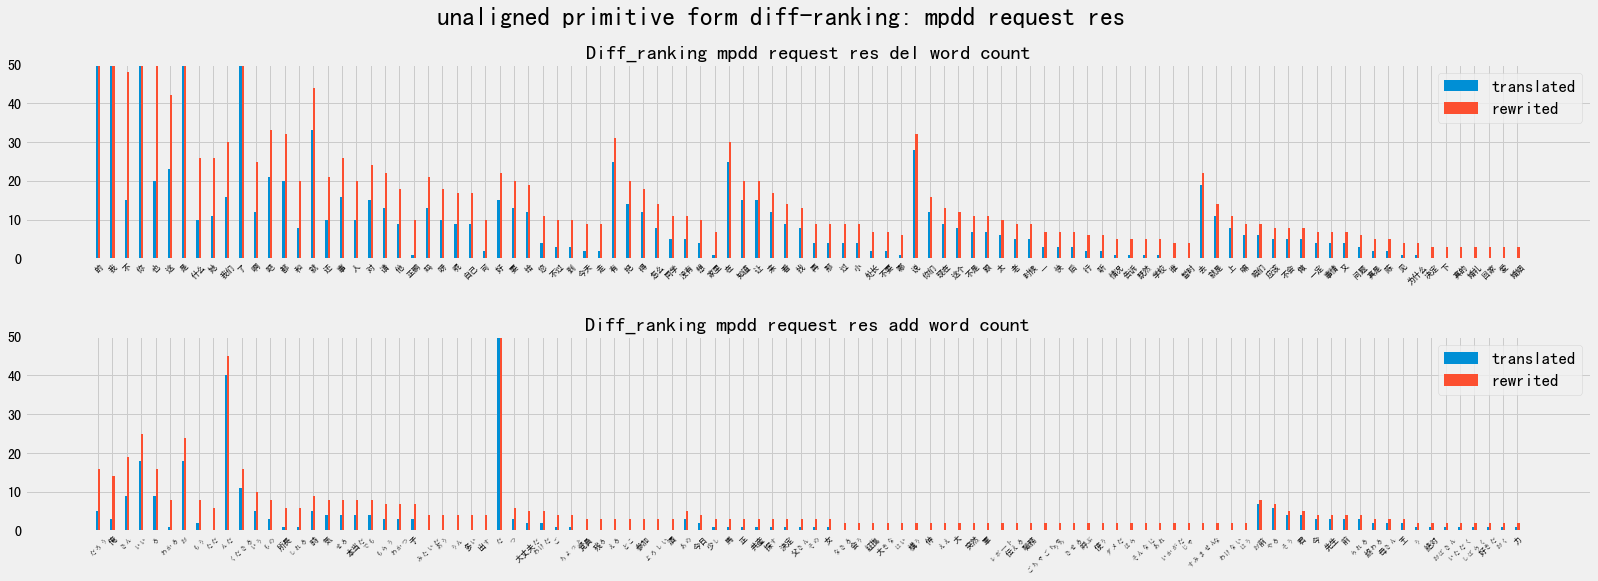

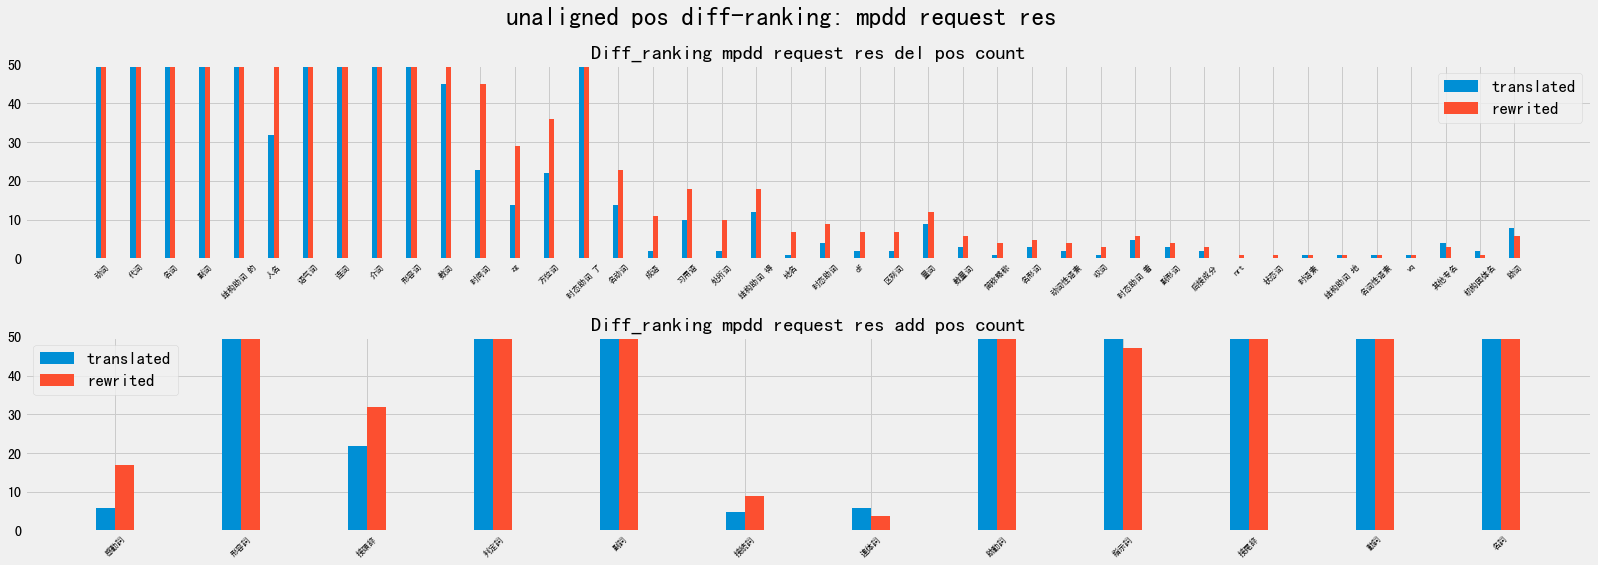

0

In [7]:
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'res')

# MPDD thanksgiving

##### 好

- Culture miss

會聽成很敷衍

[ 155 ] original    query : __好好 好__ ， 先 谢谢 你 来 ， 下次 保证 不会 ， 行 了 吧 ？

[ 155 ] translated  query : __わかった 、 わかった 、 わかった__ 、 来て くれて ありがとう 、 次 は 絶対 に し ない から ね ？

[ 155 ] rewrited    query : はい 、 大丈夫です 。 ありがとう ございます 。 次 は し ませ ん 。 気 を つけ ます 。

[ 141 ] original    query : 喂 — — 哦 宋大哥 ， 吃饭 了 吗 ？ — — 我 也 刚 吃 过 ， 有 什么 事 啊 ？ — — 工钱 的 事 啊 ？ 没 问题 你 放心 吧 ， 向 大爷 今天 和 我 说 了 ， 今晚 就 把 钱 给 我 送来 ， 明天 一早 我 给 你 送 去 。 — — 应该 的 ， 要不是 大 夥 来 帮忙 这 房子 也 盖 不 起来 啊 ， 还 得 好好 谢谢 宋大哥 呢 — — 不是 客气 ， 这 亲兄弟 还 得 明算 帐 呢 ， 是不是 ？ — — __好 的 好 的 好 的__ ， 明天 我 到 你家 去 ， 哎 ， 好 。

[ 141 ] translated  query : もしもし ・ ・ ・ あ 、 ソン 兄さん 、 もう 食べた ？ -- （ 達也 ） 俺 も 食べた とこ だ けど （ みのり ） どうした の ？ -- お 金 の こと ？ 心配 し ないで 、 今日 、 翔 様 が 今夜 お 金 を 送って くれる と 言って いた ので 、 朝 に は お 届け し ます 。 -- 私 達 の 助け が なければ この 家 は 建て られ なかった ソン 兄 に 感謝 し ます -- __わかった わかった__ 明日 家 に 行く よ

[ 141 ] rewrited    query : もしもし 、 あ 、 ソン 兄さん 。 もう 食べた ？ -- 俺 も 食べた とこ だ けど 。 どうした の ？ -- お 金 の こと ？ 心配 し ないで 、 今日 、 向 さん が 今夜 お 金 を 送って くれる と 言って た から 、 朝 に は 届け られる よ 。 当たり前じゃ ない 。 みんな が 助けて くれ なかったら 、 この 家 だって 建て られ なかった よ 、 ありがとう 。 -- いやいや 、 親しき 中 に も 礼儀 あり でしょ 。 うん 、 明日 家 に 行く よ 。

##### 关心

- culture miss？

Politeness

[ 56  ] original    query : 谢谢 ！ 谢谢 你 的 __关心__ ！ 可以 了 吧 ？ 回去 工作 吧 。

[ 56  ] translated  query : ありがとう ございます ！ __お 気遣い__ ありがとう ございます ！ （ 笑 これ で いい の か な ？ 仕事 に 戻れ

[ 56  ] rewrited    query : ありがとう ございます 。 じゃあ 、 仕事 に 戻り ましょう 。

[ 34  ] original    query : 谢谢 你 的 __关心__ 。

[ 34  ] translated  query : お __気遣い__ ありがとう ございます 。

[ 34  ] rewrited    query : ありがとう 。

##### -

- Culture miss

叫別人稱呼，聽成太刻意

[ 106 ] original    query : 真的 很 感谢 你们 俩对 我 的 关心 和 爱护 ！ 你们 俩 会 是 我 永远 的 __好 朋友 ！ 好 兄弟 ！ 好 姐妹 ！__ 所以 … …

[ 106 ] translated  query : お 二 人 の 気遣い と 愛情 に 本当に 感謝 して い ます ! お 二 人 は 一生 の __親友 で す ! い い 兄弟 だ ！ いい 姉妹 だ ！__ だ から ......

[ 106 ] rewrited    query : 本当に ありがとう 。

[ 19  ] original    query : __爸 ， 你 是 个 大好人__ ， 感谢 你 对 我 的 夸奖 我 没有 照顾 好 你 ， 真对不起 你 呀 ！ 那天 晚上 如果 没有 早睡 ， 您 老人家 也 不会 走上 黄泉路 的 ， 哎哟 ， 你 叫 我 现在 怎么 才能 弥补 这 一 过失 ！

[ 19  ] translated  query : __お 父さん 、 偉い 人 だ ね __！ 褒めて くれて ありがとう ...... 私 が 気 を 使って あげ られ なかった んだ ね ！ 本当に ごめん ね ！ 」 と 言って い ました が 、 私 が 気 を 使って あげ られ なかった の か な と 思って い ます 。 あの 夜 、 早く 寝て い なかったら 、 お前 の 爺さん は 黄泉 に 行か なかった だろう 、 痛 っ ！ 今更 、 その 過ち を どう やって 取り戻せ と 言う んだ ！ ？

[ 19  ] rewrited    query : ありがとう ございます 。 あの 時 もう 少し 遅く まで 起きて いれば 、 あの 方 も まだ ご 存命 かも しれ ない のに …… 。 どう やって お 詫び して いい の か …… 。

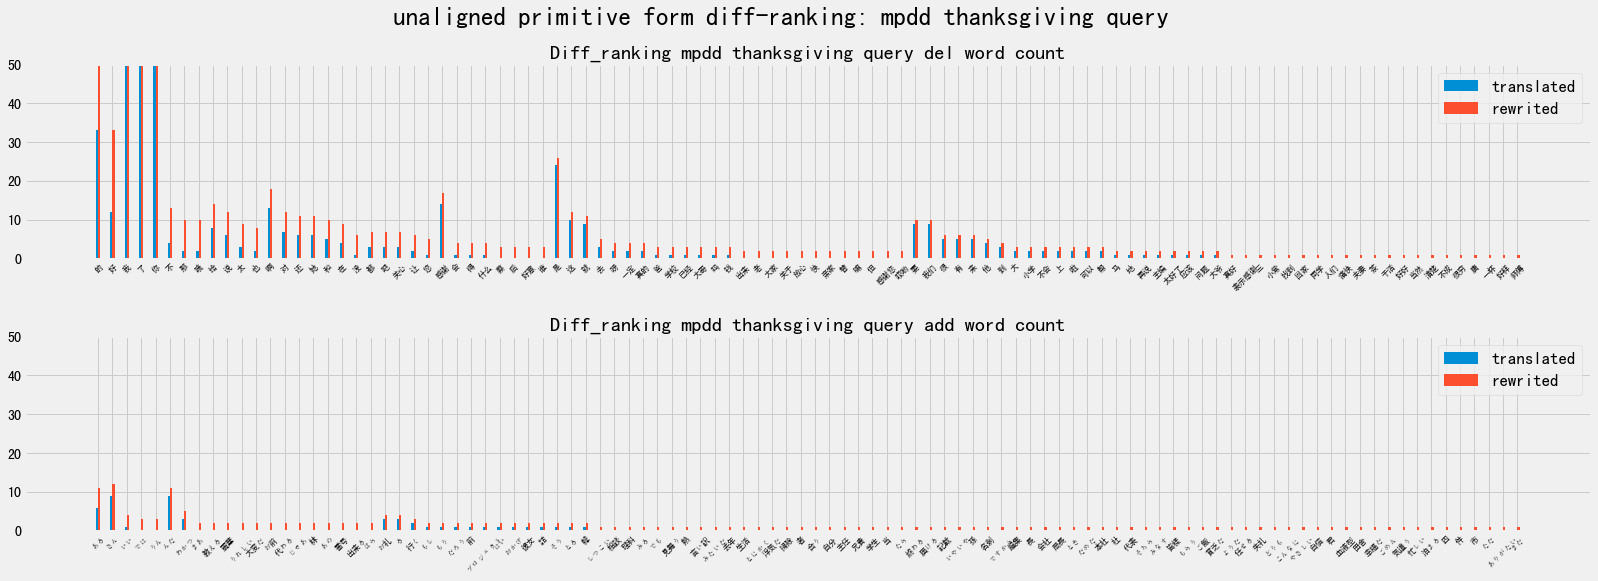

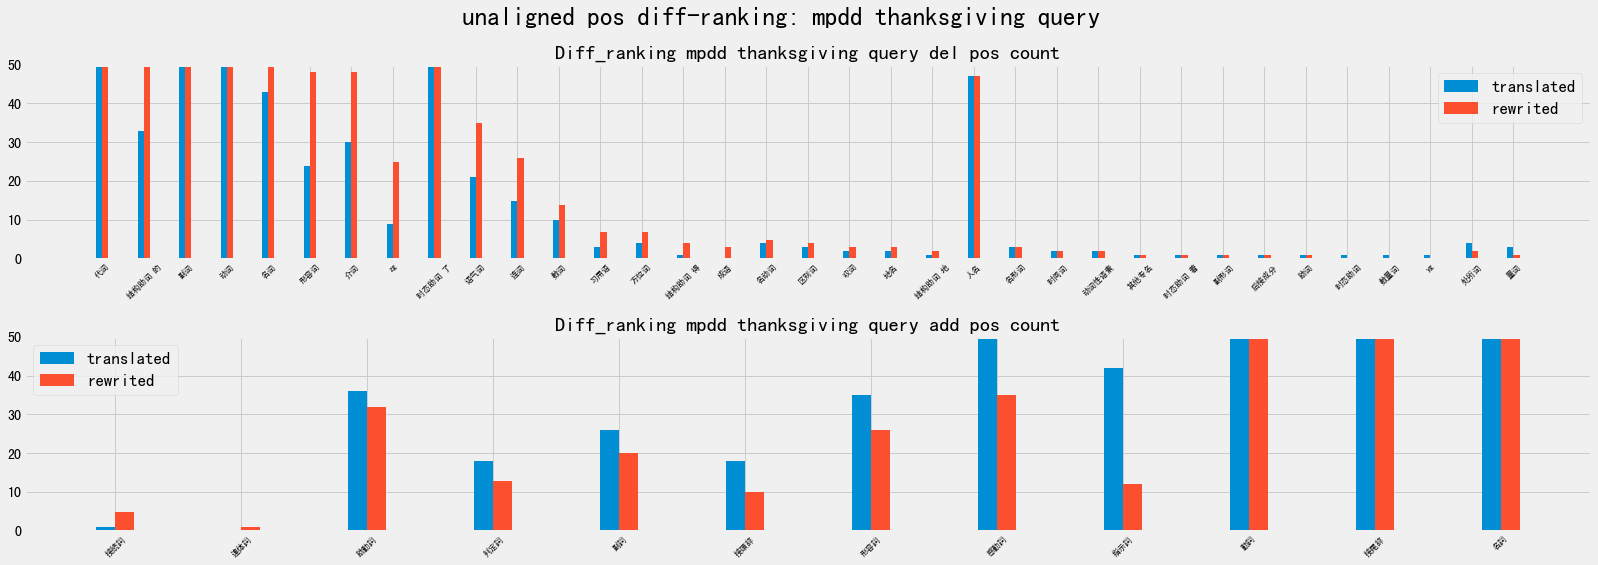

0

In [8]:
corpus = 'mpdd'
situation = 'thanksgiving'
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'query')

# MPDD thanksgiving res

##### 没什么

- Translate miss

[ 133 ] original    res   : 没什么 ， 都 是 过去 的 事 了 。

[ 133 ] translated  res   : 何でもない 、 全て 過去 の こと だ 。

[ 133 ] rewrited    res   : 気 に し ないで 、 昔 の こと だ よ 。

[ 36  ] original    res   : 没什么 ， 这 是 应该 的 。

[ 36  ] translated  res   : 何でもない 、 あるべき 姿 です 。

[ 36  ] rewrited    res   : お 気 に なさら ず 。


##### 朋友

- Culture miss

朋友不一定要帮忙

[ 35  ] original    res   : 不用谢 ， __朋友__ 嘛 应该 的 。 我 还有 事 ， 先 走 了 。 哦 ， 对 了 ， 下班 想 跟 你 说 点 事 。

[ 35  ] translated  res   : どう いたし まして 、 それ が __友達__ の 仕事 です 。 やる こと が ある ので 行って き ます 。 そう いえば 、 仕事 が 終わって から 言い たい こと が あり ます 。

[ 35  ] rewrited    res   : 気 に し ないで 。 用 が ある から 行く ね 。 あ 、 仕事 が はけたら ちょっと 言う こと が ある んだ けど 。

[ 70  ] original    res   : 没事 ， 小 爱 是 我 __朋友__ 嘛 ， 她 的 妹妹 也 就是 我 的 妹妹 嘛 。

[ 70  ] translated  res   : 大丈夫 、 愛 ちゃん は __友達__ だ し 、 お 姉ちゃん は お 姉ちゃん だ から 。

[ 70  ] rewrited    res   : いやいや 、 愛 の 妹 なら 自分 の 妹 みたいな もん だ から 。

[ 72  ] original    res   : 大家 都 是 __朋友__ ， 什么 谢不谢 的 。

[ 72  ] translated  res   : 私 たち は みんな __友達__ で 、 何の 感謝 も 感謝 も して い ませ ん 。

[ 72  ] rewrited    res   : 気 に し ないで 。

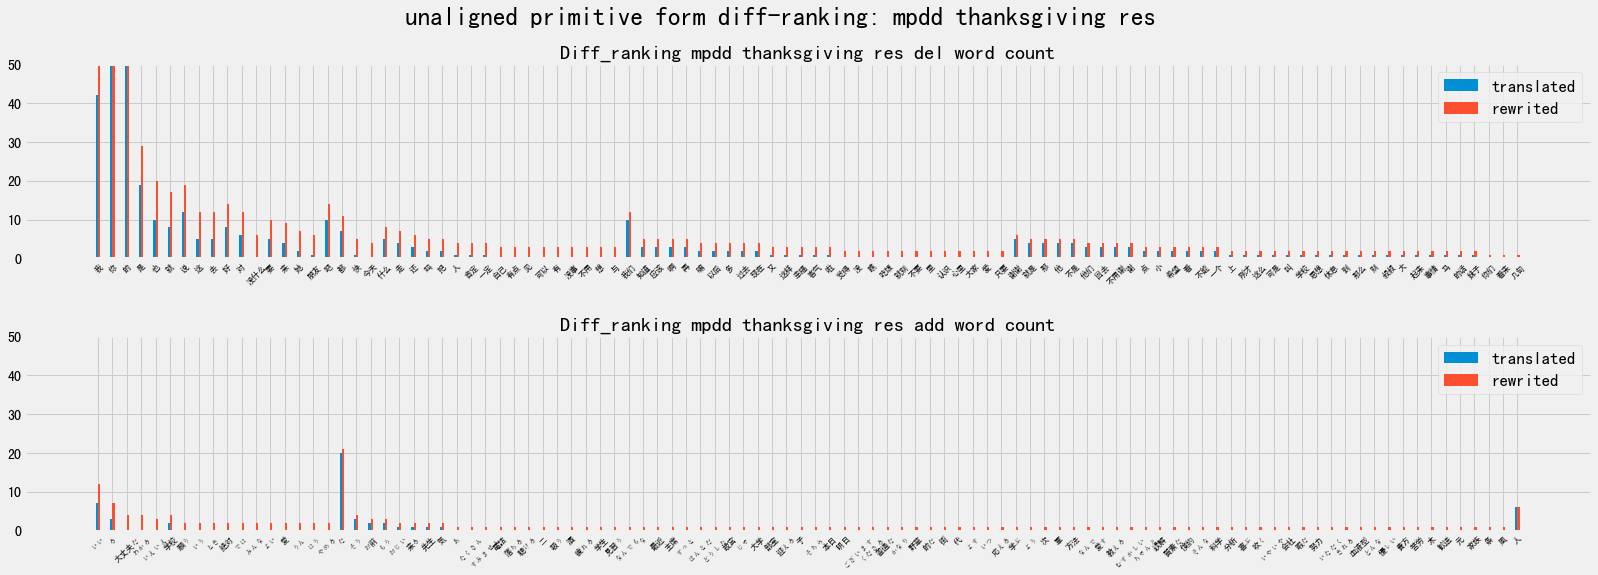

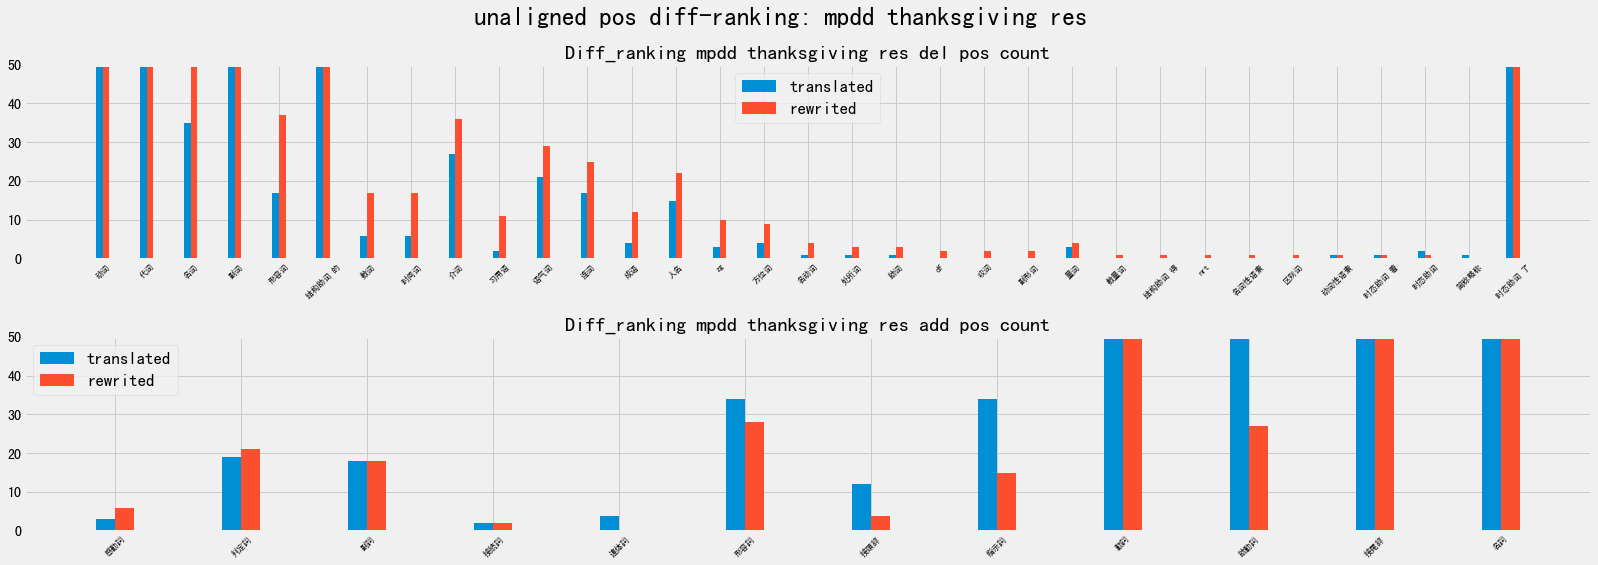

0

In [9]:
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'res')

# CEJC apology

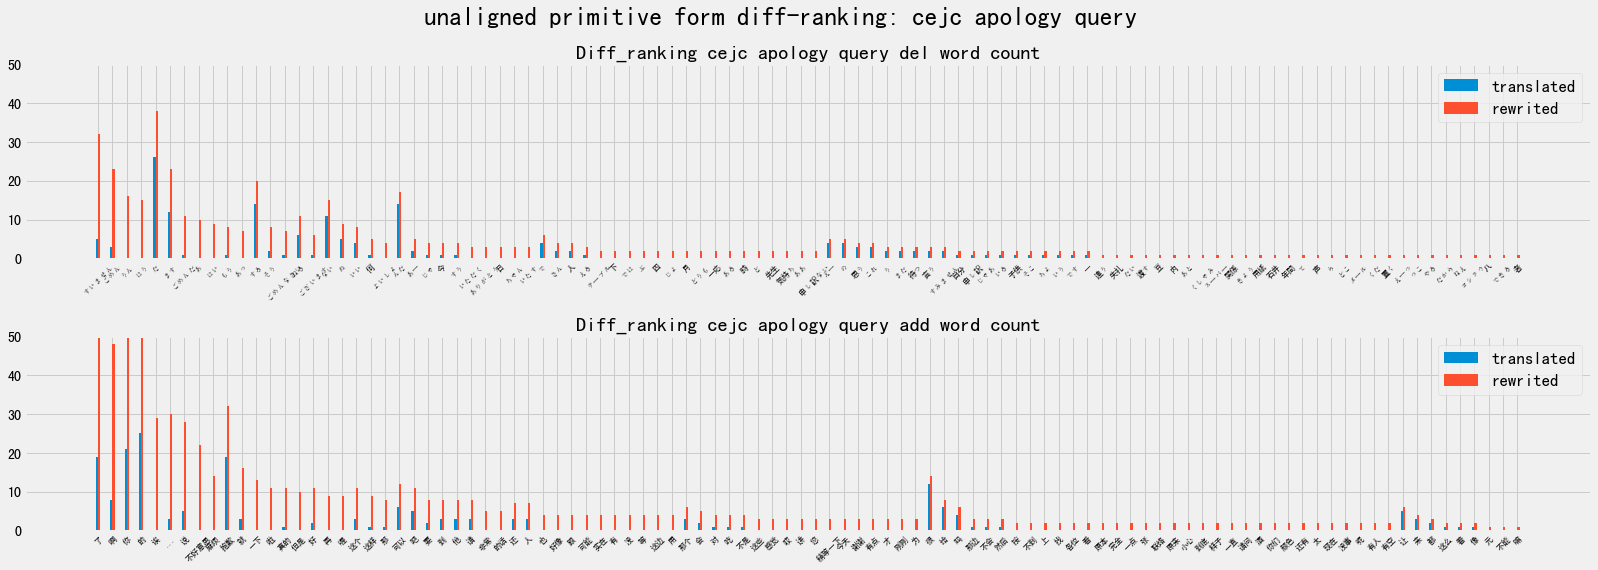

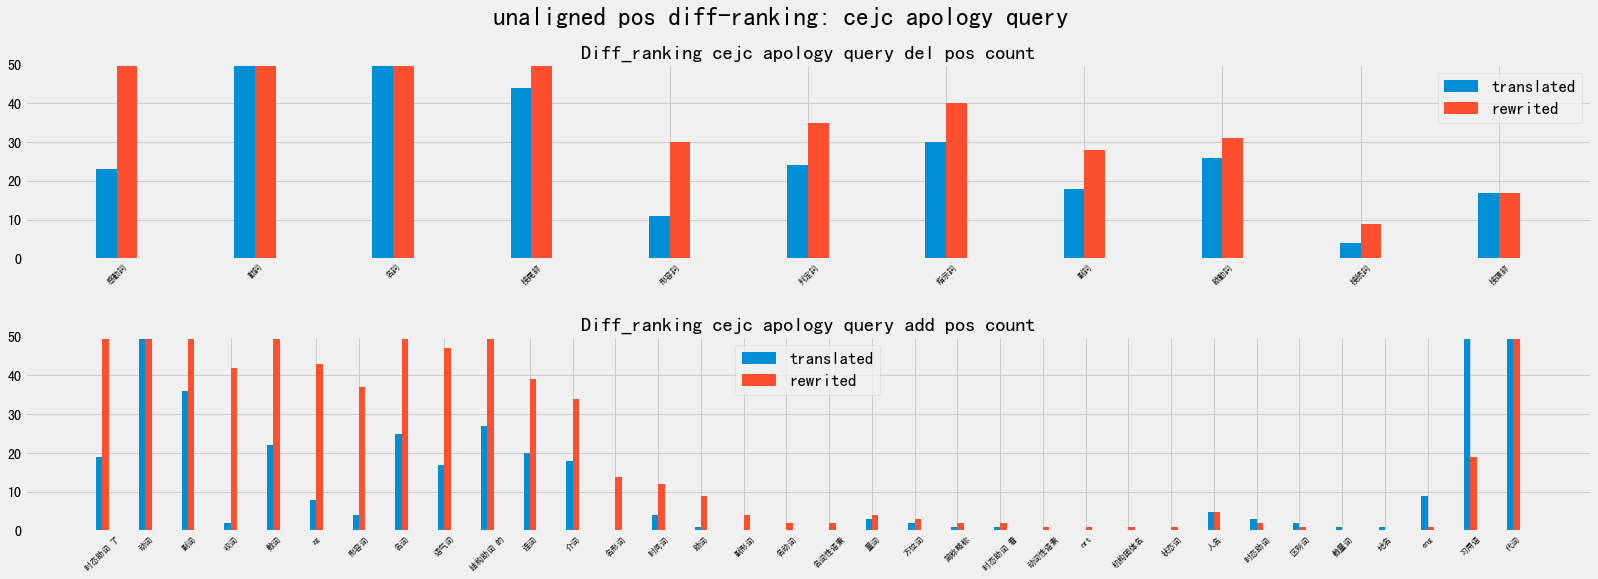

0

In [10]:
corpus = 'cejc'
situation = 'apology'
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'query')

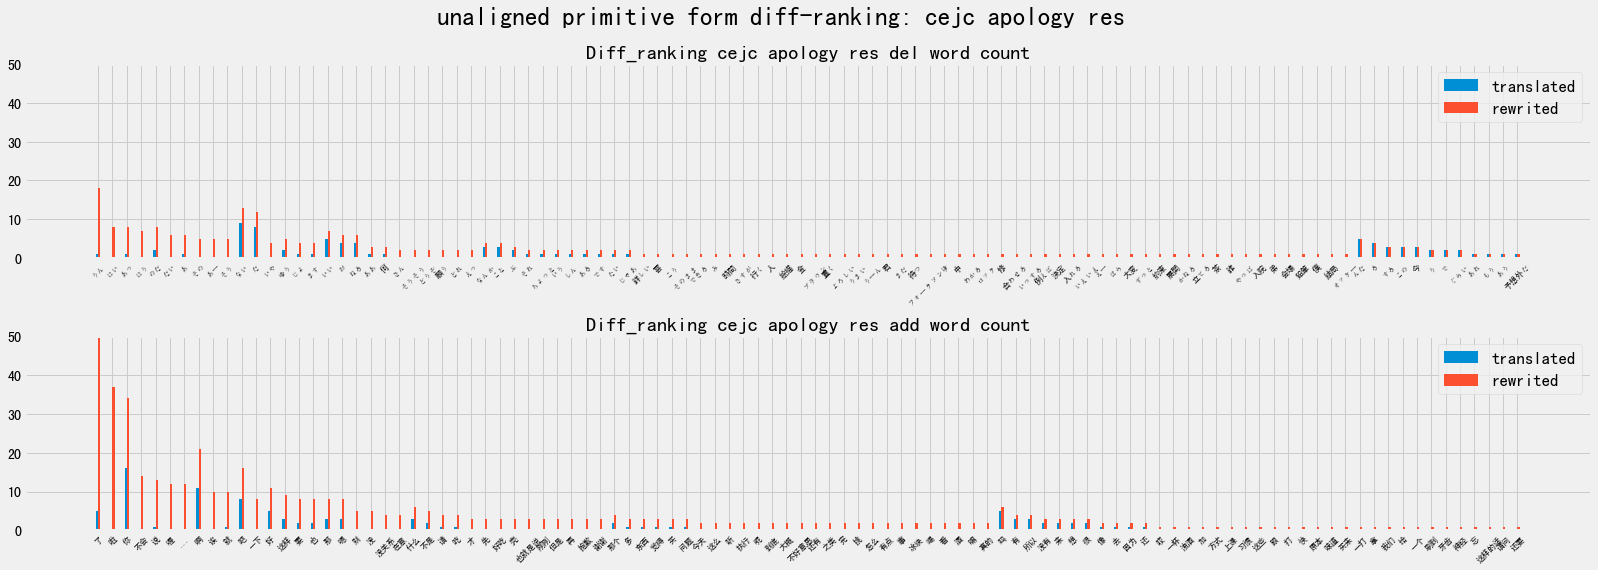

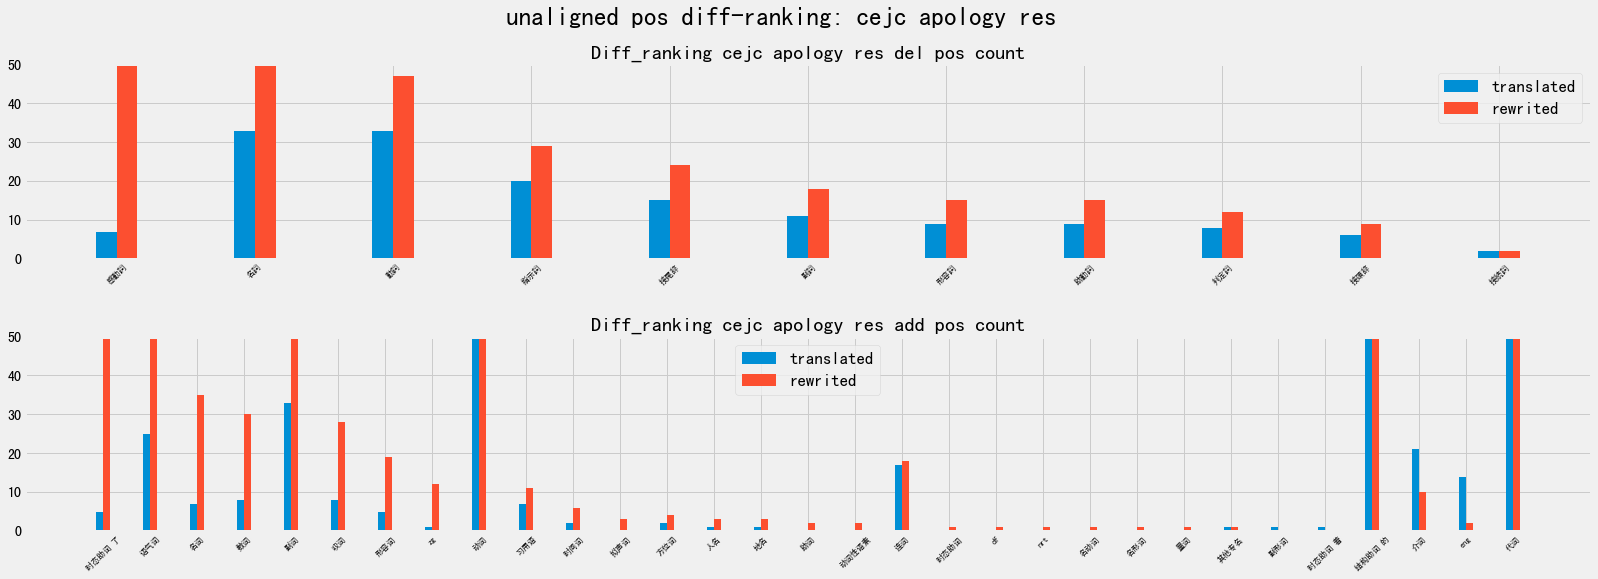

0

In [11]:
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'res')

# CEJC request

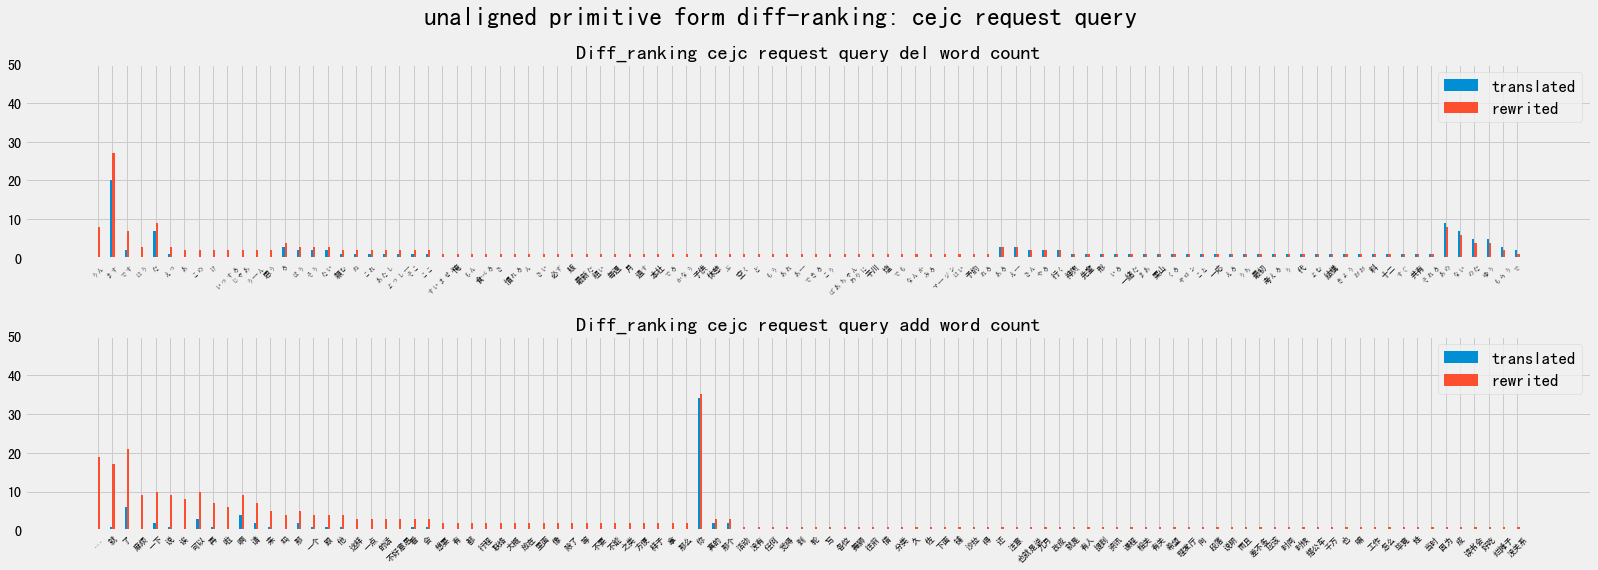

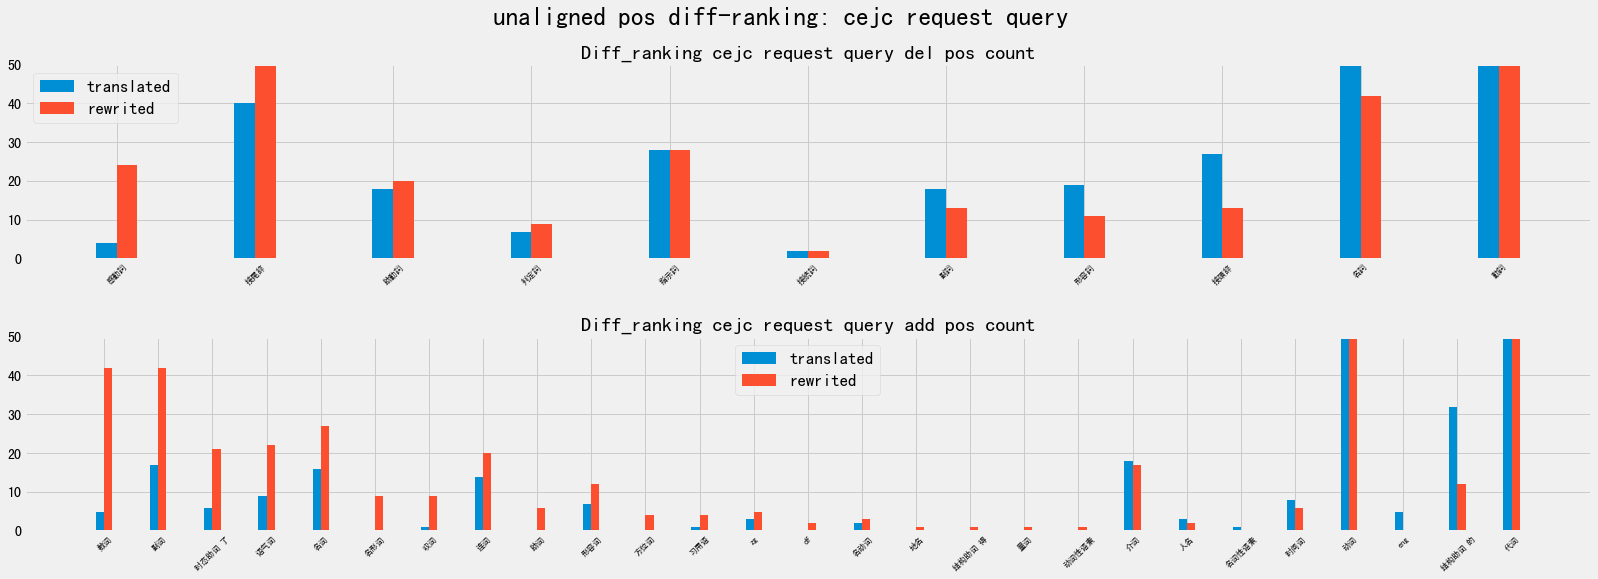

0

In [12]:
corpus = 'cejc'
situation = 'request'
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'query')

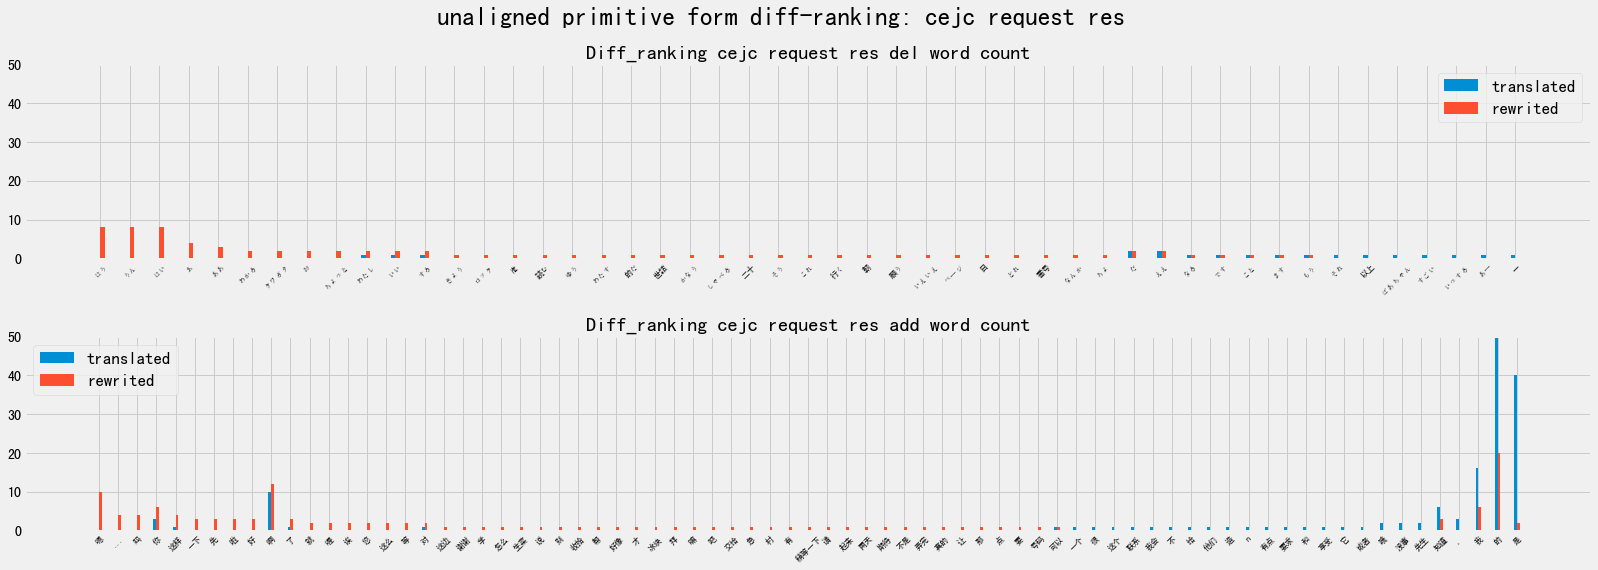

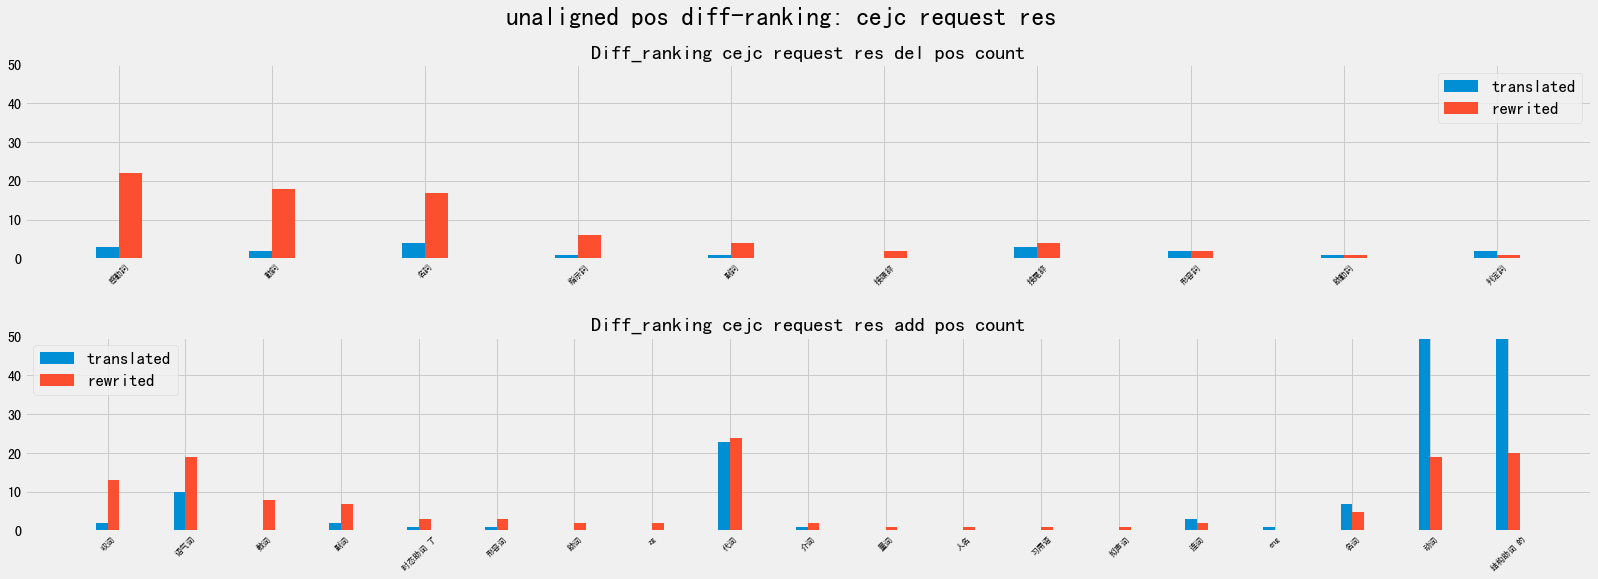

0

In [13]:
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'res')

# CEJC thanksgiving

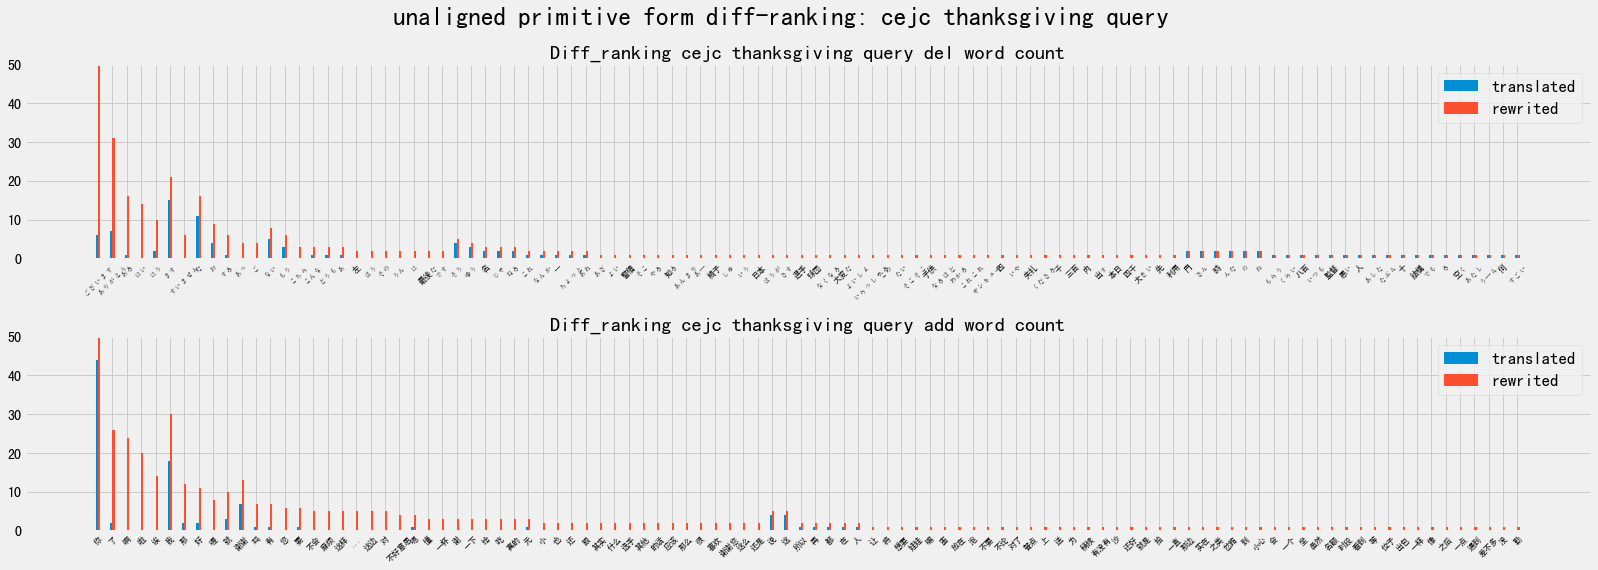

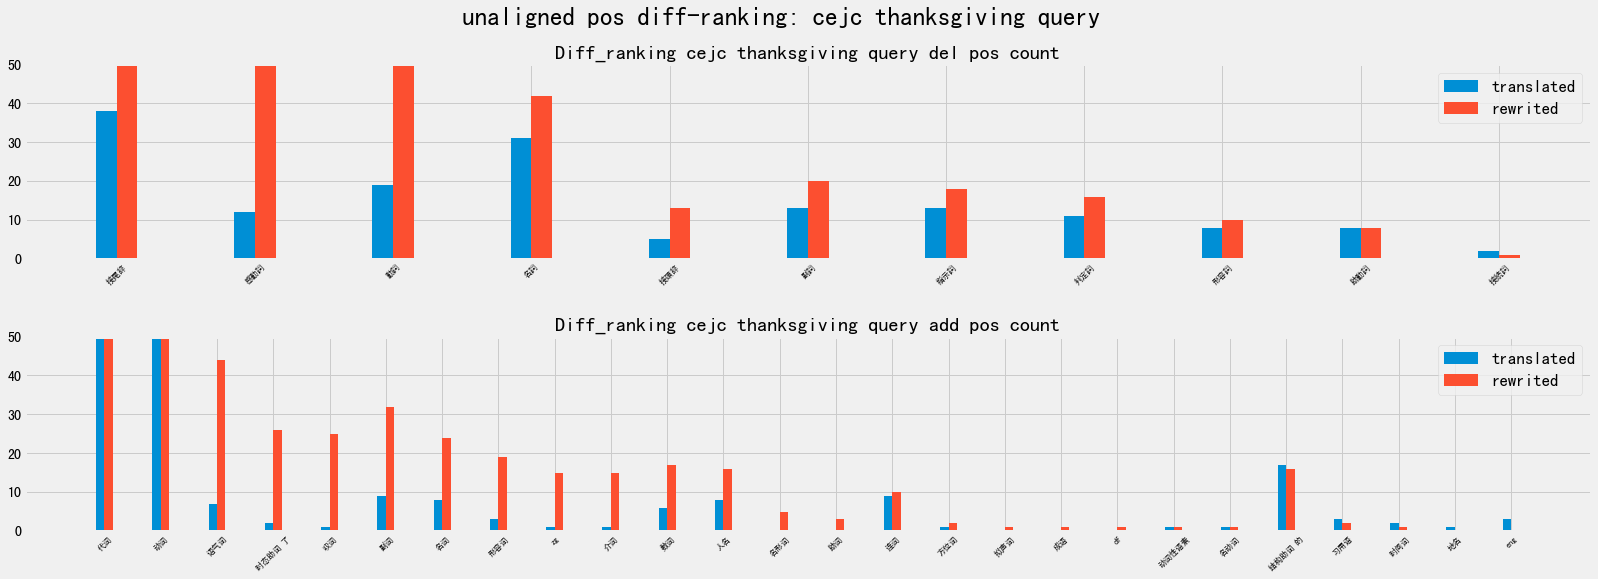

0

In [14]:
corpus = 'cejc'
situation = 'thanksgiving'
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'query')

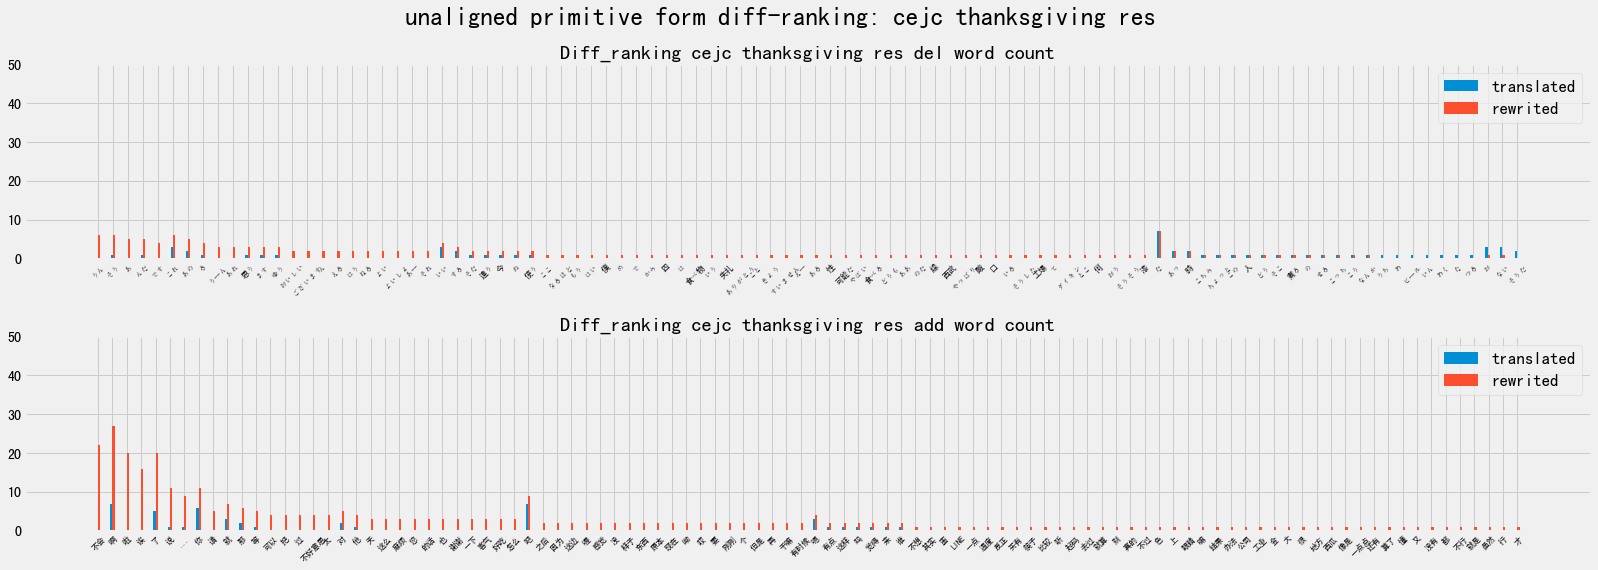

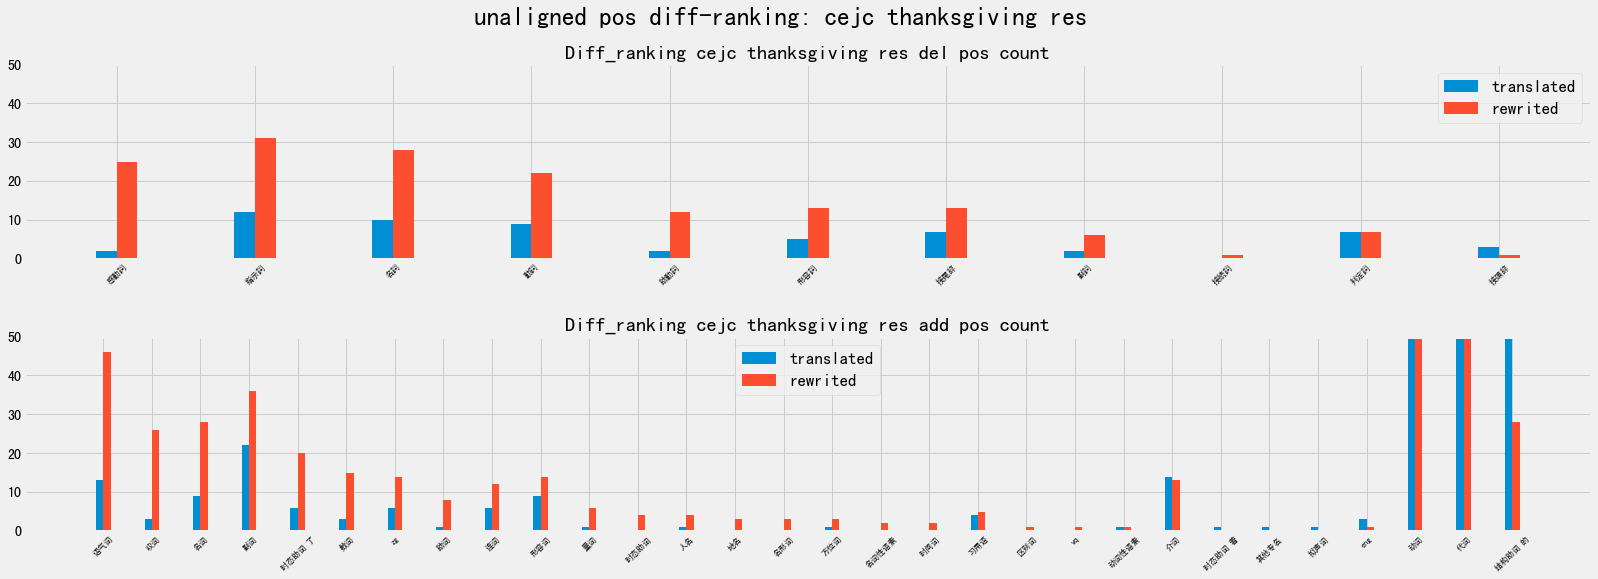

0

In [15]:
rank_by_unalighed_diff_counts_btw_methods(df,corpus,situation,'res')